# Aula 3 - Métodos ensemble
### Ensemble: Bagging x Boosting x Stacking

Ensemble nada mais é do que a sabedoria da maioria. Aqui combinamos vários modelos mais simples em um único modelo robusto a fim de reduzir o viés, variância e/ou aumentar a acurácia.
<br>


## Tipos de Ensemble:
- __1. Bagging (short for bootstrap aggregation)__: Treina paralelamente N modelos mais fracos (geralmente do mesmo tipo - homogênio) com N subsets distintos criados com amostragem randômica e reposição. Cada modelo é avaliado na fase de teste com o label definido pela moda (classificação) ou pela média dos valores (regressão). Os métodos de Bagging reduzem a variância da predição. <br>
Algoritimos  famosos: Random Forest <br>
<img src='images/bagging.png' style="width:600px"  text="http://cheatsheets.aqeel-anwar.com" />  
<br>
<br>
- __2. Boosting__: Treina N modelos mais fracos (geralmente do mesmo tipo - homogênio) de forma sequencial. Os pontos que foram classificados erroneamente recebem um peso maior para entrar no próximo modelo. Na fase de teste, cada modelo é avaliado com base do erro de teste de cada modelo, a predição é feita com um peso sobre a votação. Os métodos de Boosting reduzem o viés da predição. <br>
Algoritimos  famosos: AdaBoost, Gradient Boosting, XGBoost, CatBoost, LightGBM (Light Gradient Boosting Machine) <br>
<img src='images/boosting.png' style="width:600px" text="Fonte: http://cheatsheets.aqeel-anwar.com" />
<br>
<br>
- __3. Stacking__: Treina N modelos mais fracos (geralmente de tipos distintos - heterogênio) em um subset do conjunto de dados. Uma vez que os modelos foram treinados, cria-se um novo modelo (meta learning) para combinar a saída de cada um dos modelos mais fracos resultando na predição final. Isso é feito no segundo subset dos dados. Na fase de teste, cada modelo mais fraco faz sua predição independentemente e esses labels entram como features do meta learner para gerar a predição final.
<br>
<img src='images/stacking.png' style="width:600px" text="Fonte: http://cheatsheets.aqeel-anwar.com" />
<br>
<br>

##### Resumo:
<img src='images/comparison_img.png' style="width:600px" text="Fonte: https://quantdare.com/what-is-the-difference-between-bagging-and-boosting" />  
  
<img src='images/comparison.png' style="width:600px" />


# Boosting : AdaBoost

O AdaBoost significa **Adaptive Boosting**, e tem como procedimento geral **a criação sucessiva dos chamados weak learners**, que são modelos bem fracos de aprendizagem - geralmente, **árvores de um único nó (stumps)**.

<img src="https://miro.medium.com/max/1744/1*nJ5VrsiS1yaOR77d4h8gyw.png" width=300>

O AdaBoost utiliza os **erros da árvore anterior para melhorar a próxima árvore**. As predições finais são feitas com base **nos pesos de cada stump**, cuja determinação faz parte do algoritmo!

<img src="https://static.packt-cdn.com/products/9781788295758/graphics/image_04_046-1.png" width=700>

Vamos entender um pouco melhor...

Aqui, o bootstrapping não é utilizado: o método começa treinando um classificador fraco **no dataset original**, e depois treina diversas cópias adicionais do classificador **no mesmo dataset**, mas dando **um peso maior às observações que foram classificadas erroneamente** (ou, no caso de regressões, a observações **com o maior erro**).

Assim, após diversas iterações, classificadores/regressores vão sequencialmente "focando nos casos mais difíceis", e construindo um classificador encadeado que seja forte, apesar de utilizar diversos classificadores fracos em como elementos fundamentais.

<img src="https://www.researchgate.net/profile/Zhuo_Wang8/publication/288699540/figure/fig9/AS:668373486686246@1536364065786/Illustration-of-AdaBoost-algorithm-for-creating-a-strong-classifier-based-on-multiple.png" width=500>

De forma resumida, as principais ideias por trás deste algoritmo são:

- O algoritmo cria e combina um conjunto de **modelos fracos** (em geral, stumps);
- Cada stump é criado **levando em consideração os erros do stump anterior**;
- Alguns dos stumps têm **maior peso de decisão** do que outros na predição final;

As classes no sklearn são:

- [AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)

- [AdaBoostRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html#sklearn.ensemble.AdaBoostRegressor)

Note que não há muitos hiperparâmetros. O mais importante, que deve ser tunado com o grid/random search, é:

- `n_estimators` : o número de weak learners encadeados;

Além disso, pode também ser interessante tunar os hiperparâmetros dos weak learners. Isso é possível de ser feito, como veremos a seguir!


## Na prática

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split

from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [2]:
# criar uma função de preprocessamento
def pipe_pre_process_german(df, X, y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # ==========================================================

    pipe_features_num = Pipeline([("input_num", SimpleImputer(strategy="mean")),
                                  ("std", StandardScaler())])

    features_num = X_train.select_dtypes(include=np.number).columns.tolist()

    # ==========================================================

    pipe_features_cat = Pipeline([("input_cat", SimpleImputer(strategy="constant", fill_value="unknown")),
                                  ("onehot", OneHotEncoder())])

    features_cat = X_train.select_dtypes(exclude=np.number).columns.tolist()

    # ==========================================================

    pre_processador = ColumnTransformer([("transf_num", pipe_features_num, features_num),
                                         ("transf_cat", pipe_features_cat, features_cat)])

    return X_train, X_test, y_train, y_test, pre_processador

In [3]:
# métricas de classificação (para avaliação do modelo)
def metricas_classificacao(estimator, X_train, X_test, y_train, y_test):
    
    # ============================================

    print("\nMétricas de avaliação de treino:")

    y_pred_train = estimator.predict(X_train)

    print(confusion_matrix(y_train, y_pred_train))

    ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
    plt.show()

    print(classification_report(y_train, y_pred_train))


    # ============================================

    print("\nMétricas de avaliação de teste:")

    y_pred_test = estimator.predict(X_test)

    print(confusion_matrix(y_test, y_pred_test))

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
    plt.show()

    print(classification_report(y_test, y_pred_test))
    

## Vamos aplicar o novo modelo

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# modulos referentes ao AdaBoost
from sklearn.ensemble import AdaBoostClassifier

In [6]:
df = pd.read_csv("../datasets/german_credit_data.csv", index_col=0)

X = df.drop(columns="Risk")
y = df["Risk"]

X_train, X_test, y_train, y_test, pre_processador = pipe_pre_process_german(df, X, y)

pipe_ab = Pipeline([("pre_processador", pre_processador),
                    ("AdaBoost", AdaBoostClassifier(random_state=42))])

pipe_ab.fit(X_train, y_train)

Pipeline(steps=[('pre_processador',
                 ColumnTransformer(transformers=[('transf_num',
                                                  Pipeline(steps=[('input_num',
                                                                   SimpleImputer()),
                                                                  ('std',
                                                                   StandardScaler())]),
                                                  ['Age', 'Job',
                                                   'Credit amount',
                                                   'Duration']),
                                                 ('transf_cat',
                                                  Pipeline(steps=[('input_cat',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder())]),
                                                  ['Sex', 'Housing',
                                                   'Saving accounts',
                                                   'Checking account',
                                                   'Purpose'])])),
                ('AdaBoost', AdaBoostClassifier(random_state=42))])


Métricas de avaliação de treino:
[[123 117]
 [ 59 501]]


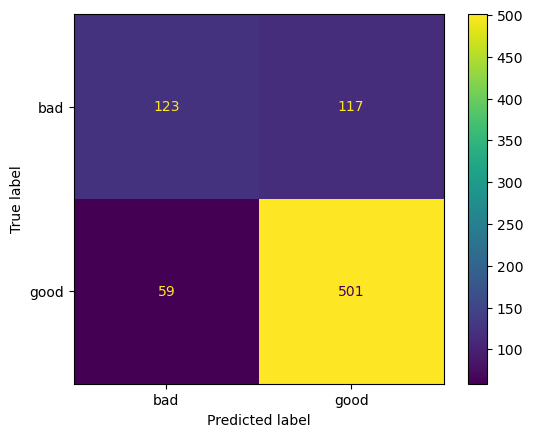

              precision    recall  f1-score   support

         bad       0.68      0.51      0.58       240
        good       0.81      0.89      0.85       560

    accuracy                           0.78       800
   macro avg       0.74      0.70      0.72       800
weighted avg       0.77      0.78      0.77       800


Métricas de avaliação de teste:
[[ 29  31]
 [ 18 122]]


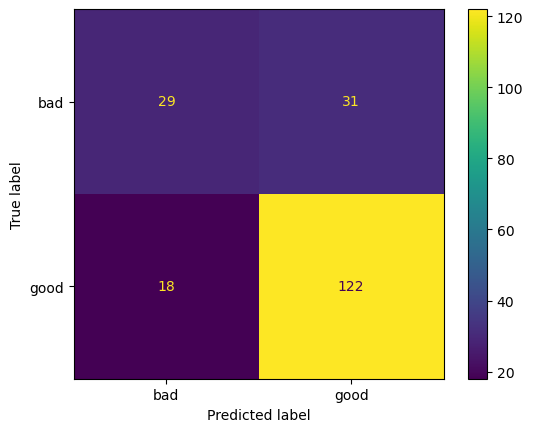

              precision    recall  f1-score   support

         bad       0.62      0.48      0.54        60
        good       0.80      0.87      0.83       140

    accuracy                           0.76       200
   macro avg       0.71      0.68      0.69       200
weighted avg       0.74      0.76      0.75       200



In [7]:
# avaliação do modelo
metricas_classificacao(pipe_ab, X_train, X_test, y_train, y_test)

Usando n_estimator = 150 - estou chutando um valor. O ideal é fazer um grid/randomsearch

In [8]:
pipe_ab = Pipeline([("pre_processador", pre_processador),
                    ("AdaBoost", AdaBoostClassifier(random_state=42, n_estimators=150))])

pipe_ab.fit(X_train, y_train)

Pipeline(steps=[('pre_processador',
                 ColumnTransformer(transformers=[('transf_num',
                                                  Pipeline(steps=[('input_num',
                                                                   SimpleImputer()),
                                                                  ('std',
                                                                   StandardScaler())]),
                                                  ['Age', 'Job',
                                                   'Credit amount',
                                                   'Duration']),
                                                 ('transf_cat',
                                                  Pipeline(steps=[('input_cat',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder())]),
                                                  ['Sex', 'Housing',
                                                   'Saving accounts',
                                                   'Checking account',
                                                   'Purpose'])])),
                ('AdaBoost',
                 AdaBoostClassifier(n_estimators=150, random_state=42))])


Métricas de avaliação de treino:
[[135 105]
 [ 55 505]]


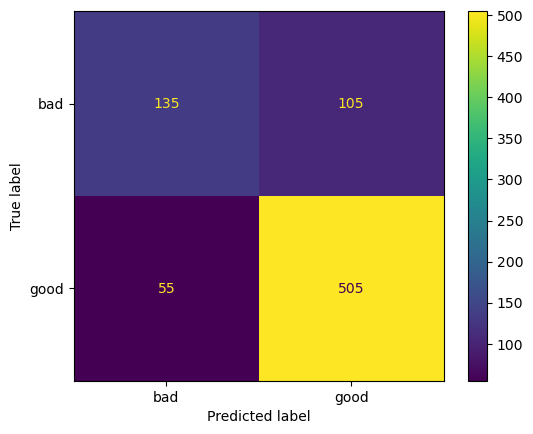

              precision    recall  f1-score   support

         bad       0.71      0.56      0.63       240
        good       0.83      0.90      0.86       560

    accuracy                           0.80       800
   macro avg       0.77      0.73      0.75       800
weighted avg       0.79      0.80      0.79       800


Métricas de avaliação de teste:
[[ 31  29]
 [ 17 123]]


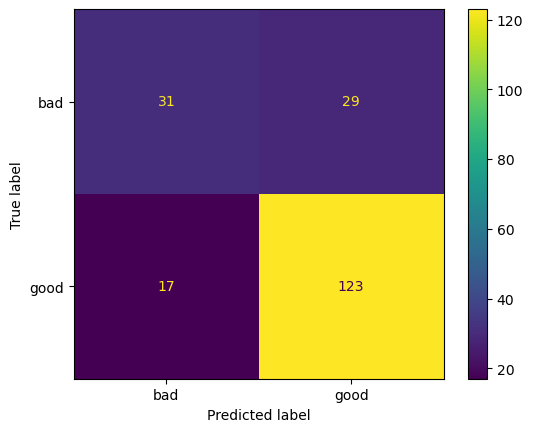

              precision    recall  f1-score   support

         bad       0.65      0.52      0.57        60
        good       0.81      0.88      0.84       140

    accuracy                           0.77       200
   macro avg       0.73      0.70      0.71       200
weighted avg       0.76      0.77      0.76       200



In [10]:
metricas_classificacao(pipe_ab, X_train, X_test, y_train, y_test)